In [6]:
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from scipy import interpolate

#YEAR TO PROCESS
yeart='2008'
montht='01'

#OCCIPUT SDL INTERPOLATION
OCCI = '/home1/ballycotton/DATA/PIRATE/SDL_INTERP/'+yeart+'/'
patho = glob.glob(os.path.join(OCCI+'*'+montht+'.nc'))

#ISAS PROFILES
ISAS = '/home/lpo4/ISAS_LPO/ANA_ISAS15_ARGO/data/'+yeart+'/'
pathi = glob.glob(os.path.join(ISAS+'*'+yeart+montht+'15_dat_*.nc'))

#OPEN
OCC=xr.open_dataset(patho[0],decode_times=False,mask_and_scale=True)
ISA_S=xr.open_dataset(pathi[0],decode_times=False,mask_and_scale=True)
ISA_T=xr.open_dataset(pathi[1],decode_times=False,mask_and_scale=True)
#GEOSUBSET ISAS
ISA_T=ISA_T.where((ISA_T.LATITUDE>20) & (ISA_T.LATITUDE<45) & (ISA_T.LONGITUDE>-85) & (ISA_T.LONGITUDE<-30),drop=True)
ISA_S=ISA_S.where((ISA_S.LATITUDE>20) & (ISA_S.LATITUDE<45) & (ISA_S.LONGITUDE>-85) & (ISA_S.LONGITUDE<-30),drop=True)

#REMOVE FIRST LEVEL (0m)
OCC=OCC.where(OCC.STANDARD_LEVELS<0,drop=True)
# ALIGN VARIABLES ALONG ONE DIMENSION 
OCC['A']=OCC.JULD.min(dim='N_LEVELS')
OCC['B']=OCC.STATION_IDENTIFIER.min(dim='N_LEVELS')
OCC['C']=OCC.LATITUDE.min(dim='N_LEVELS')
OCC['D']=OCC.LONGITUDE.min(dim='N_LEVELS')
OCC=OCC.drop(['JULD','STATION_IDENTIFIER','LATITUDE','LONGITUDE'])
OCC=OCC.rename({'A':'JULD','B':'STATION_IDENTIFIER','C':'LATITUDE','D':'LONGITUDE'})
print OCC

<xarray.Dataset>
Dimensions:             (N_LEVELS: 299, N_MEMBER: 50, N_OBS: 122)
Dimensions without coordinates: N_LEVELS, N_MEMBER, N_OBS
Data variables:
    STANDARD_LEVELS     (N_LEVELS) float64 -5.0 -10.0 -15.0 -20.0 -25.0 ...
    POTM_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 17.67 17.67 ...
    TEMP_OBS            (N_OBS, N_LEVELS) float64 18.16 18.16 18.15 18.15 ...
    CYCLE_NUMBER        (N_OBS, N_LEVELS) float64 116.0 116.0 116.0 116.0 ...
    POTM_OBS            (N_OBS, N_LEVELS) float64 18.15 18.15 18.15 18.15 ...
    PSAL_OBS            (N_OBS, N_LEVELS) float64 36.23 36.23 36.23 36.23 ...
    PSAL_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 35.91 35.91 ...
    JULD                (N_OBS) float64 2.118e+04 2.118e+04 2.118e+04 ...
    STATION_IDENTIFIER  (N_OBS) object '4900525 ' '4900800 ' '4900789 ' ...
    LATITUDE            (N_OBS) float64 39.15 20.8 27.12 28.3 41.95 28.06 ...
    LONGITUDE           (N_OBS) float64 -39.93 -53.74 -51.07 -76.28 -53.14 

In [28]:
print ISA_T.TEMP-ISA_T.TEMP_RESI

<xarray.DataArray (N_PROF: 660, N_LEVELS: 152)>
array([[24.316448, 24.3164  , 24.316406, ...,       nan,       nan,       nan],
       [24.269041, 24.268517, 24.268082, ...,       nan,       nan,       nan],
       [24.181982, 24.18848 , 24.190876, ...,       nan,       nan,       nan],
       ...,
       [15.051146, 15.047636, 15.046041, ...,  3.606738,  3.604312,       nan],
       [14.99275 , 14.991835, 14.995605, ...,  3.598809,       nan,       nan],
       [15.793038, 15.79192 , 15.791849, ...,  3.653607,       nan,       nan]],
      dtype=float32)
Dimensions without coordinates: N_PROF, N_LEVELS


In [9]:
#ISAS MATCHING LOOKUP ARRAY
IST= xr.Dataset({'PLATFORM_NUMBER': (['JULD'],  ISA_T.PLATFORM_NUMBER),
                'LATITUDE': (['JULD'], ISA_T.LATITUDE),
                'LONGITUDE': (['JULD'], ISA_T.LONGITUDE),
                'TEMP': (['JULD','N_LEVELS'], ISA_T.TEMP-ISA_T.TEMP_RESI),                
                'DEPH': (['N_LEVELS','JULD'], ISA_T.DEPH),                
                },
                 coords={'JULD': ISA_T.JULD.values})
ISS= xr.Dataset({'PLATFORM_NUMBER': (['JULD'],  ISA_S.PLATFORM_NUMBER),
                'LATITUDE': (['JULD'], ISA_S.LATITUDE),
                'LONGITUDE': (['JULD'], ISA_S.LONGITUDE),
                'PSAL': (['JULD','N_LEVELS'], ISA_S.PSAL-ISA_S.PSAL_RESI),                
                'DEPH': (['N_LEVELS','JULD'], ISA_S.DEPH),                
                },
                 coords={'JULD': ISA_S.JULD.values})

In [10]:
OCC['FIND']= xr.DataArray(np.zeros(len(OCC.N_OBS))+1,dims= {'N_OBS'})
OCC['TEMP_ISAS'] = xr.DataArray(np.zeros([len(OCC.N_OBS),299]),dims= {'N_OBS','N_LEVELS'})
OCC['PSAL_ISAS'] = xr.DataArray(np.zeros([len(OCC.N_OBS),299]),dims= {'N_OBS','N_LEVELS'})

In [11]:
for i in OCC.N_OBS.values :
    A1t=IST.where(IST.PLATFORM_NUMBER.isin([OCC.STATION_IDENTIFIER[i].values]),drop=True)    
    A1s=ISS.where(ISS.PLATFORM_NUMBER.isin([OCC.STATION_IDENTIFIER[i].values]),drop=True) 
    A1t=A1t.sortby(A1t.JULD)
    A1s=A1s.sortby(A1s.JULD)
    if (len(A1s.JULD)>0):             
        A2t=A1t.sel(JULD=[OCC.JULD[i].values],method='nearest')
        A2s=A1s.sel(JULD=[OCC.JULD[i].values],method='nearest')
        if(abs(A2t.JULD.values-OCC.JULD[i].values)<0.1):
            #INTERPOLATE ISAS PROFILE ON SDT LEVEL            
            ft = interpolate.interp1d(A2t.DEPH[:,0], A2t.TEMP[0,:])
            fs = interpolate.interp1d(A2s.DEPH[:,0], A2s.PSAL[0,:])
            OCC.TEMP_ISAS[i,:] = ft(-OCC.STANDARD_LEVELS.values)
            OCC.PSAL_ISAS[i,:] = fs(-OCC.STANDARD_LEVELS.values)           
    else:
        OCC.FIND[i]=0        
OCC=OCC.where(OCC.FIND==1,drop=True)        
OCC['STANDARD_LEVELS'] = OCC['STANDARD_LEVELS'].isel(N_OBS=0)
OCC=OCC.drop('FIND')

In [12]:
print OCC

<xarray.Dataset>
Dimensions:             (N_LEVELS: 299, N_MEMBER: 50, N_OBS: 122)
Dimensions without coordinates: N_LEVELS, N_MEMBER, N_OBS
Data variables:
    STANDARD_LEVELS     (N_LEVELS) float64 -5.0 -10.0 -15.0 -20.0 -25.0 ...
    POTM_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 17.67 17.67 ...
    TEMP_OBS            (N_OBS, N_LEVELS) float64 18.16 18.16 18.15 18.15 ...
    CYCLE_NUMBER        (N_OBS, N_LEVELS) float64 116.0 116.0 116.0 116.0 ...
    POTM_OBS            (N_OBS, N_LEVELS) float64 18.15 18.15 18.15 18.15 ...
    PSAL_OBS            (N_OBS, N_LEVELS) float64 36.23 36.23 36.23 36.23 ...
    PSAL_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 35.91 35.91 ...
    JULD                (N_OBS) float64 2.118e+04 2.118e+04 2.118e+04 ...
    STATION_IDENTIFIER  (N_OBS) object '4900525 ' '4900800 ' '4900789 ' ...
    LATITUDE            (N_OBS) float64 39.15 20.8 27.12 28.3 41.95 28.06 ...
    LONGITUDE           (N_OBS) float64 -39.93 -53.74 -51.07 -76.28 -53.14 

<IPython.core.display.Javascript object>


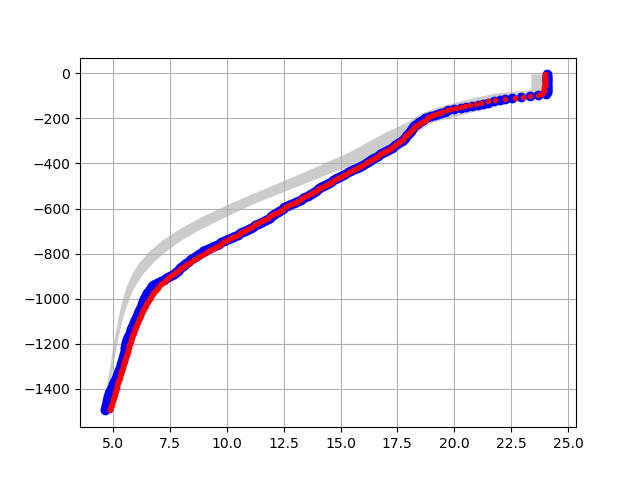

In [21]:
%matplotlib notebook
indx=86
plt.grid(True)
plt.plot(OCC.TEMP_OBS[indx,:],OCC.STANDARD_LEVELS,'bo')
plt.plot(OCC.TEMP_ISAS[indx,:],OCC.STANDARD_LEVELS,'r.')
plt.fill_betweenx(OCC.STANDARD_LEVELS,
                  OCC.POTM_Hx[:,indx,:].min('N_MEMBER'),
                  OCC.POTM_Hx[:,indx,:].max('N_MEMBER'),
                  facecolor='gray', alpha=0.4)